In [7]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Load pickup/dropoff point summary and drop malformed rows
df_counts = pd.read_csv("99_pickup_dropoff_counts.csv")
df_counts.columns = ["geometry_wkt", "departures", "arrivals"]
df_counts = df_counts[df_counts["geometry_wkt"].str.startswith("POINT")]

# Convert to GeoDataFrame
gdf_counts = gpd.GeoDataFrame(
    df_counts,
    geometry=df_counts["geometry_wkt"].apply(wkt.loads),
    crs="EPSG:4326"
).to_crs("EPSG:3857")

# Load and prepare community areas
areas_df = pd.read_csv("test_data/CommAreas_20250422.csv")
areas_df["geometry"] = areas_df["the_geom"].apply(wkt.loads)
areas_gdf = gpd.GeoDataFrame(areas_df, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:3857")
areas_summary = areas_gdf.set_index("COMMUNITY")

# Spatial join: assign each point to a community
joined = gpd.sjoin(gdf_counts, areas_summary, how="inner", predicate="within")

# Group and join back to areas
summary = joined.groupby("COMMUNITY")[["departures", "arrivals"]].sum()
plot_gdf = areas_summary.join(summary, how="left").fillna(0)

In [8]:
def plot_choropleth_with_labels(gdf, column, title, cmap):
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf.plot(column=column, cmap=cmap, legend=True, edgecolor="white", ax=ax)

    label_map = {
        "ENGLEWOOD": "ENGLE-\nWOOD",
        "WEST ENGLEWOOD": "WEST\nENGLE-\nWOOD",
        "GRAND BOULEVARD": "GRAND\nBOULE-\nVARD",
        "BRIDGEPORT": "BRIDGE-\nPORT"
    }

    for idx, row in gdf.iterrows():
        if row[column] > 0:
            x, y = row.geometry.representative_point().coords[0]
            label = label_map.get(idx, "\n".join(idx.split()))
            ax.text(x, y, label, fontsize=5.5, ha="center", va="center", color="black")

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def plot_difference_map_with_labels(gdf, col1="departures", col2="arrivals", title="Pickup vs Dropoff Balance"):
    gdf["diff"] = gdf[col1] - gdf[col2]
    vmax = 2000  # adjust for more contrast

    fig, ax = plt.subplots(figsize=(12, 12))
    gdf.plot(column="diff", cmap="bwr", legend=True, edgecolor="white",
             vmin=-vmax, vmax=vmax, ax=ax)

    label_map = {
        "ENGLEWOOD": "ENGLE-\nWOOD",
        "WEST ENGLEWOOD": "WEST\nENGLE-\nWOOD",
        "GRAND BOULEVARD": "GRAND\nBOULE-\nVARD",
        "BRIDGEPORT": "BRIDGE-\nPORT"
    }

    for idx, row in gdf.iterrows():
        if row["diff"] != 0:
            x, y = row.geometry.representative_point().coords[0]
            label = label_map.get(idx, "\n".join(idx.split()))
            ax.text(x, y, label, fontsize=5.5, ha="center", va="center", color="black")

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

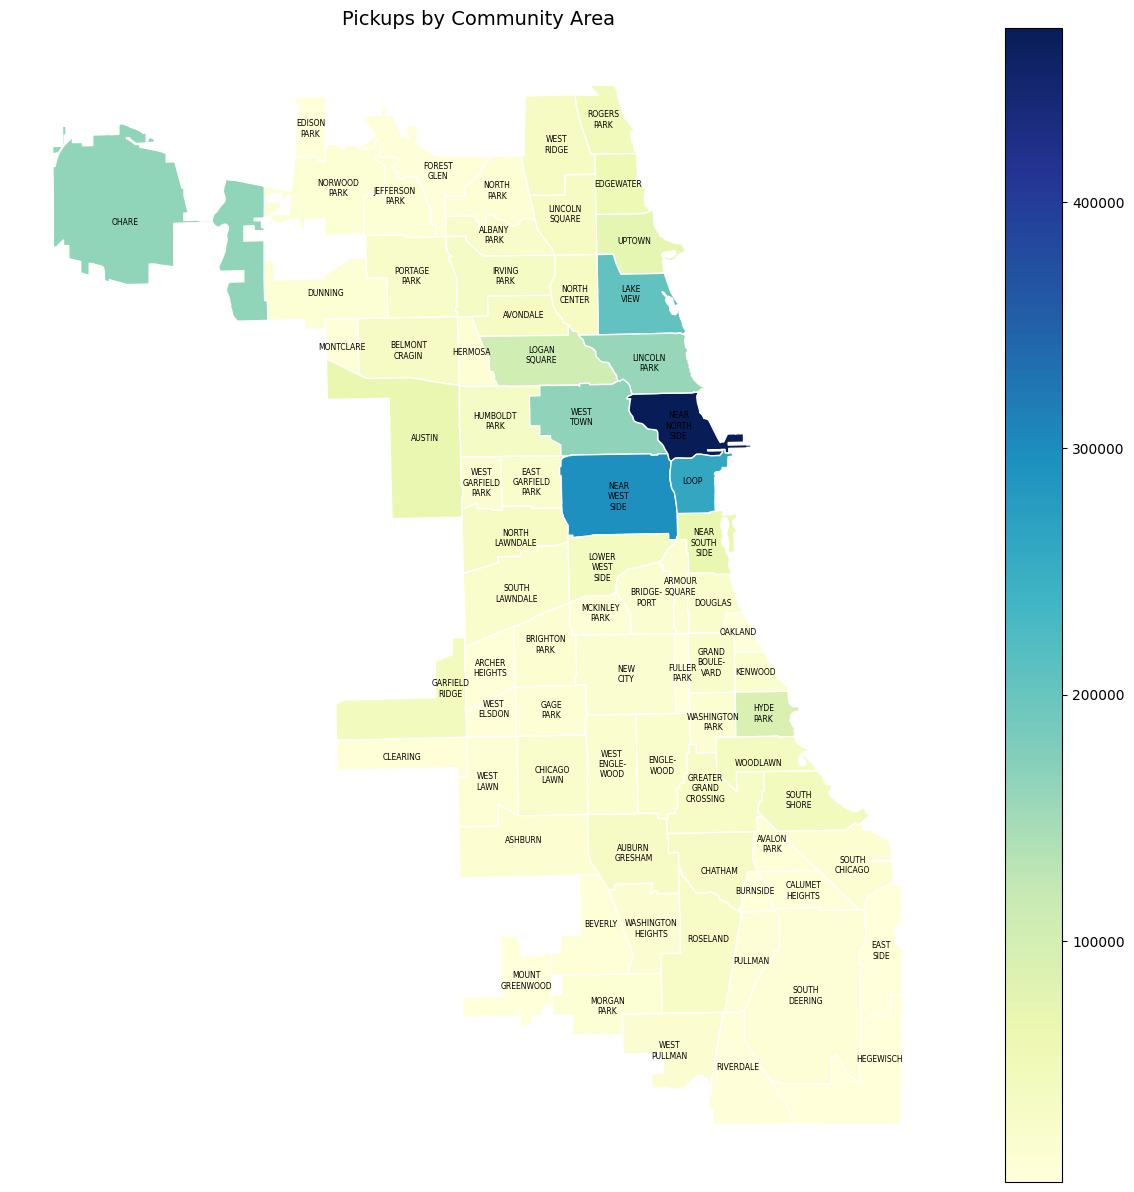

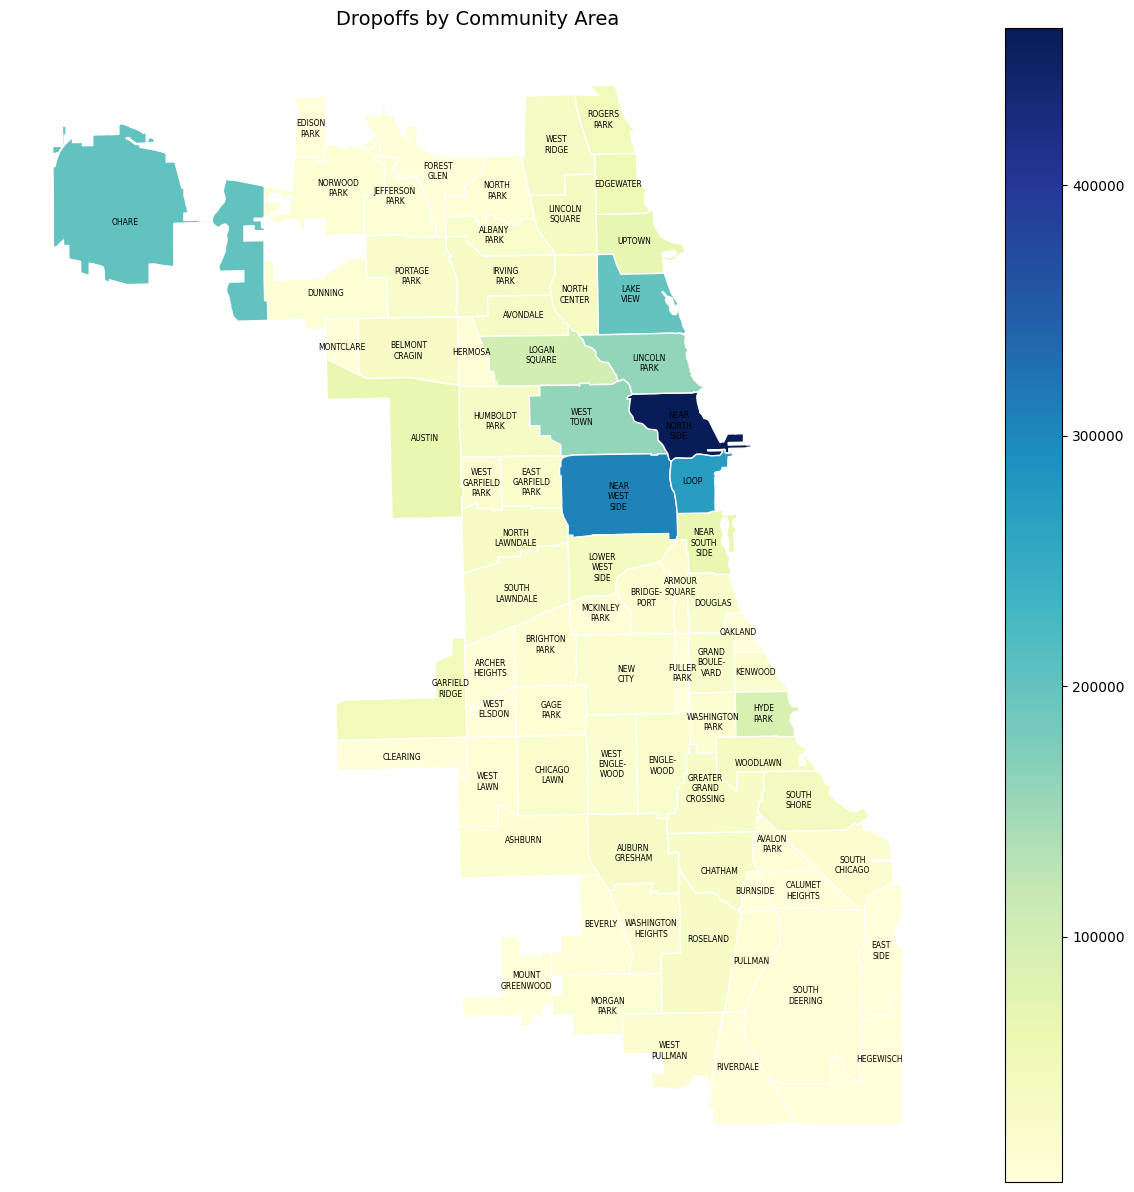

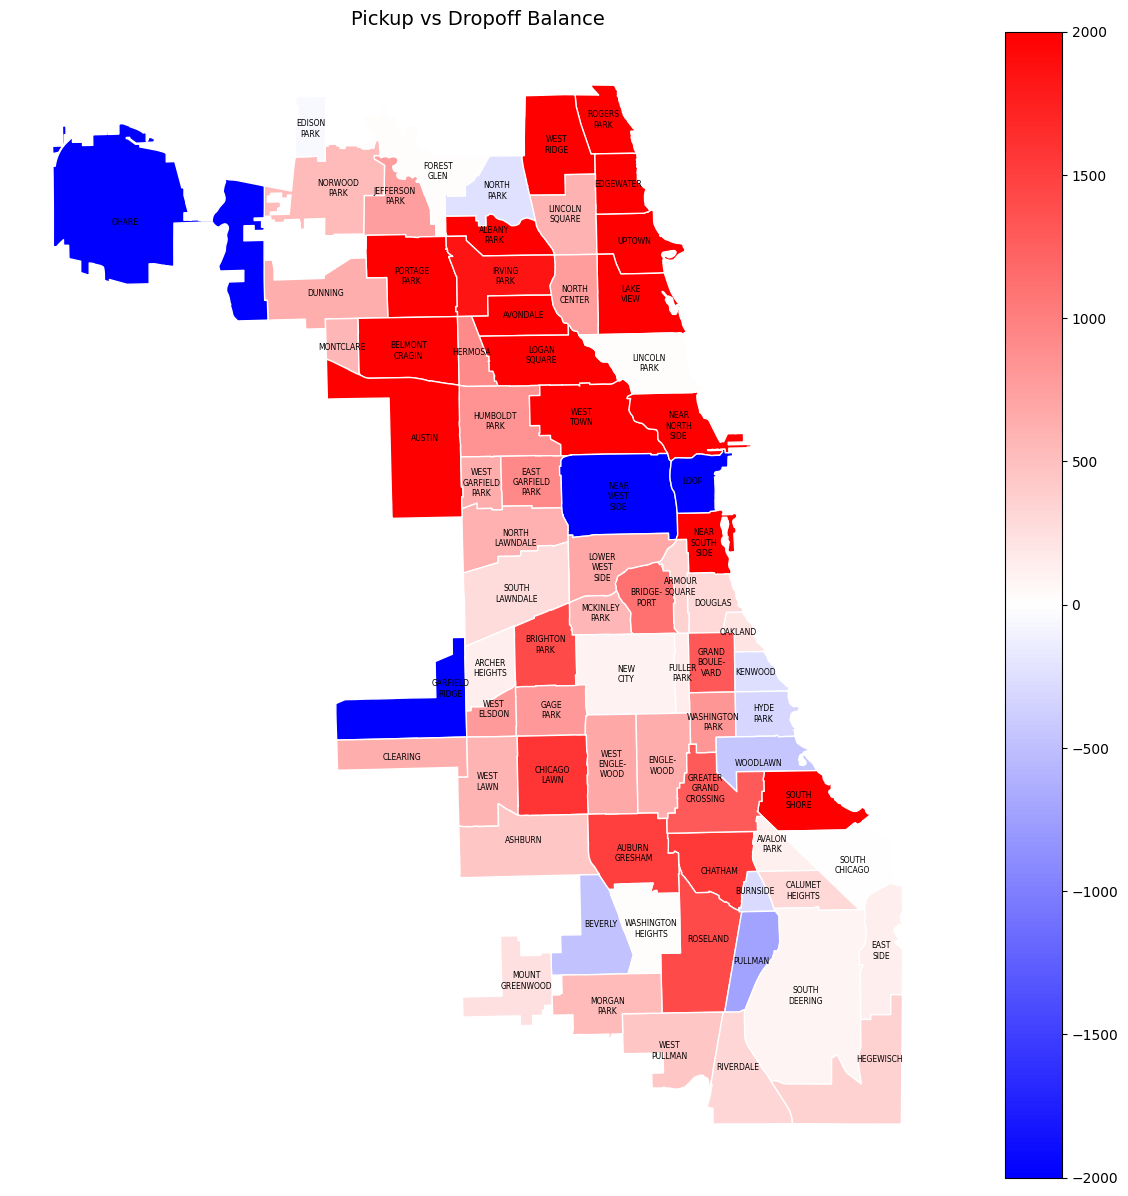

In [3]:
plot_choropleth_with_labels(plot_gdf, "departures", "Pickups by Community Area", cmap="YlGnBu")
plot_choropleth_with_labels(plot_gdf, "arrivals", "Dropoffs by Community Area", cmap="YlGnBu")
plot_difference_map_with_labels(plot_gdf)